# IMPORT

In [1]:
!pip install seaborn==0.10.1
!pip install -U scikit-learn

    100% |████████████████████████████████| 225kB 13.5MB/s ta 0:00:01
  Found existing installation: seaborn 0.8.1
    Uninstalling seaborn-0.8.1:
      Successfully uninstalled seaborn-0.8.1
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 6.9MB 7.0MB/s eta 0:00:01
Requirement not upgraded as not directly required: numpy>=1.13.3 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (1.14.6)
    100% |████████████████████████████████| 307kB 39.8MB/s ta 0:00:01
Requirement not upgraded as not directly required: scipy>=0.19.1 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (1.1.0)
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
You are using pip version 10.0.1, h

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import psutil
import re

# magic word for producing visualizations in notebook
%matplotlib inline

# CUSTOM FUNCTIONS

In [3]:
def remove_high_corr(corr, threshold, output_high_corr=False):
    """
    Only  keep one element from a chain of highly (> threshold) correlated elements
    
    Parameters:
    -----------
    corr (pandas.DataFrame) : the correlation matrix
    threshold (float) : the threshold above which a high correlation is considered between elements
    
    Returns:
    --------
    if not output_high_corr:
    (main_elements, correlated_elements) (tuple) : a tuple containing two lists featuring respectively the main elements (to be kept)
                                                   and the correlated elements with the main elements (to be discarded)
    if output_high_corr:
    (-, -, high_corr) : same as above + high_corr which provides a dictionnary providing pairs of highly correlated variables 
    
    """
    
    indices = np.where(corr > threshold)
    high_corr = {corr.index[x] : corr.columns[y] for x, y in zip(*indices)
                                        if x != y and x < y}
    main_elements = []
    correlated_elements = []
    
    for key in high_corr.keys():
        if (key not in main_elements) and (key not in correlated_elements):
            main_elements.append(key)
            correlated_elements.append(high_corr[key])
        elif key in correlated_elements:
            correlated_elements.append(high_corr[key])
        else:
            continue
    
    if not output_high_corr:
        return (main_elements, correlated_elements)
    else:
        return (main_elements, correlated_elements, high_corr)
        

In [4]:
def drop_full_empty_row(df, df_name=None):
    """
    Drop completely empty rows from  a dataframe
    
    Parameters:
    -----------
    df (pandas.DataFrame) : DataFrame to be processed
    df_name (str) : a human-understandble name of the dataframe for messaging about operations
    
    Returns:
    --------
    None
    """
    if not df_name:
        df_name = "DataFrame"
        
    print(f'Before deletion of full empty rows, we have {len(df)} samples in {df_name} data')
    df.dropna(axis=0, how='all')
    print(f'After deletion of full empty rows, we have {len(df)} samples in {df_name} data')   


In [5]:
def remove_insignificant_columns(df, thresh = 0.8):
    """
    Removes columns where NaN counts / total values exceed thresh
    
    Parameters:
    -----------
    df (pandas.DataFrame) : DataFrame to be processed
    thresh (float) : threshold for deleting columns
    
    Returns:
    --------
    list of removed columns
    
    """
    removed_col = []
    
    total_count  = df.shape[0]
    
    for col in df.columns:
        nan_count = df[col].isna().sum()
        if nan_count/total_count > thresh:
            df.drop(col, axis=1, inplace=True)
            print(f'column {col} has been dropped')
            removed_col.append(col)
    
    return removed_col

In [6]:
def make_replacement(df, replacement):
    """
    replace values in a dataframe according to a dictionnary
    
    Parameters:
    -----------
    df (pandas.DataFrame) : the dataframe on which replacements must be made
    replace (dict) : a dictionnary whose keys are (some) of the columns of df and whose values are dictionnaries 
                     providing {value_to_be_replaced : value_to_replace}
                     
    Returns:
    --------
    None
    
    
    """
    for col in df.columns[1:]:
        if col in replacements.keys():
            df.loc[:,col].replace(replacements[col])

In [7]:
def fill_na_presc(df, nan_fill):
    """
    fill NaN values of df with prescription of nan_fill
    
    Parameters:
    -----------
    df (pandas.DataFrame) : Dataframe on which NaN will be replaced
    nan_fill (pandas.DaTaframe) : DataFrame providing the rules for NaN replacement
    
    Returns:
    --------
    None
    
    Remarks:
    --------
    nan_fill shall have its index corresponding to columns in df in which one desires to replace NaN values
    NaN values in df get found via .isna() of pandas
    nan_fill.loc[col, "Value"] shall provide the replacement value for NaN found in column col of df
    ! first column of df is skipped
    ! TODO : make it generic and parameterized

    """
    for col in df.columns[1:] :# skip first column which is an ID, not an attribute
        if col in nan_fill.index:
            try:
                df.loc[df[col].isna()==True, col] = nan_fill.loc[col, "Value"]
            except Exception as e:
                if "Cannot setitem" in str(e):
                    # if no unknown category yet in that column, add the value to the categories
                    df[col].cat.set_categories(np.hstack((df[col].cat.categories.values,
                                     nan_fill.loc[col, "Value"])), inplace=True)
                    df.loc[df[col].isna()==True, col] = nan_fill.loc[col, "Value"]
                else:
                    print(e)

In [27]:
def df_to_numeric(df):
    column_not_converted = []
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='raise')
        except Exception as e:
            print(f'column {col} could not be converted to numeric')
            column_not_converted.append(col)
    return column_not_converted

In [28]:
def get_non_numeric(df):
    non_numeric = []
    for col in df.columns:
        if df[col].dtype not in (np.float64, np.int64):
            non_numeric.append(col)
    return non_numeric

# DATA STORAGE TO S3

In [10]:
import sagemaker
session = sagemaker.session.Session
bucket = 'auto-ml-exploration'

In [13]:
s3_dataset_path = f's3://{bucket}/dataset'

sagemaker.s3.S3Uploader.upload('Udacity_AZDIAS_052018.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_CUSTOMERS_052018.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_MAILOUT_052018_TEST.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_MAILOUT_052018_TRAIN.csv', s3_dataset_path)

# LOAD DATA PARTIAL

In [15]:
# data location on S3
pop_dataset_loc = f's3://{bucket}/dataset/Udacity_AZDIAS_052018.csv'
customers_dataset_loc = f's3://{bucket}/dataset/Udacity_CUSTOMERS_052018.csv'

# partial loading
# load in the data, first only a few rows to get an idea
# I had a memory issue when loading the complete file
# 1 every 2 rows
pop_df_partial = pd.read_csv(pop_dataset_loc, sep=';', skiprows = lambda x: x%2) # skiprows because much data... Let's see if one can convert some to categorical to reduce memory usage
customers_df_partial = pd.read_csv(customers_dataset_loc, sep=';', skiprows = lambda x: x%2)

# Store columns names
customers_categories = customers_df_partial.columns
pop_categories = pop_df_partial.columns

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# DATA EXPLORATION - Non Visual

In [6]:
pop_df_partial.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
1,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
2,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0
3,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1.0,1.0,1.0
4,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4.0,2.0,3.0


## Display info

In [7]:
pop_df_partial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363212 entries, 0 to 363211
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(289), int64(71), object(6)
memory usage: 1014.2+ MB


In [137]:
corr = pop_df_partial.corr()
(main_elements, correlated_elements) = remove_high_corr(corr, 0.7)

TypeError: remove_high_corr() missing 1 required positional argument: 'threshold'

In [139]:
correlated_elements

['ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'PRAEGENDE_JUGENDJAHRE',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'LP_LEBENSPHASE_GROB',
 'FINANZ_SPARER',
 'FINANZ_SPARER',
 'CJT_TYP_5',
 'CJT_TYP_5',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_VERSAND_ANZ_24',
 'ONLINE_AFFINITAET',
 'VK_DHT4A',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_TELKO_ANZ_24',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSI_ANZ_24',
 'STRUKTURTYP',
 'FINANZ_SPARER',
 'LP_STATUS_GROB',
 'FINANZ_UNAUFFAELLIGER',
 'GEBAEUDETYP_RASTER',
 'VERS_TYP',
 'KBA05_MAXAH',
 'KBA05_SEG6',
 'MOBI_REGIO',
 'KBA05_KRSAQUOT',
 'KBA05_SEG2',
 'KBA05_MOTOR',
 'KBA05_SEG6',
 'MOBI_REGIO',
 'KBA05_KRSHERST1',
 'KBA05_KRSHERST2',
 'KBA05_KRSHERST3',
 'KBA05_SEG6',
 'KBA05_SEG6',
 'KBA05_SEG9',
 'KBA05_ZUL4',
 'KBA05_SEG2',
 'KBA05_SEG5',
 'KBA05_SEG6',
 'KBA05

In [11]:
# Let's check which columns are object
pop_df_partial.select_dtypes(object)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,8A,8,51,NaN,1992-02-10 00:00:00,W
1,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
2,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W
3,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
4,1E,1,15,D19_KOSMETIK,1992-02-10 00:00:00,W
5,NaN,NaN,NaN,NaN,NaN,NaN
6,5C,5,33,D19_VOLLSORTIMENT,2009-01-19 00:00:00,W
7,8B,8,41,D19_UNBEKANNT,1992-02-12 00:00:00,W
8,NaN,NaN,NaN,NaN,NaN,NaN
9,5D,5,34,NaN,1992-02-12 00:00:00,W


In [76]:
# It seems weird that columns CAMEO_DEUG_2015 & CAMEO_INTL_2015 get mapped to object
# let's check them in more details
col = 'CAMEO_DEUG_2015'
print(f'type of column {col} before processing is {type(pop_df_partial.loc[25, col])}')

# this outputs a string and string are handled as objects by Pandas
# However, a better type would be float or int
# so for appropriate columns, one will want to cast them as float64 or int64

# this can be achieved through pandas to_numeric method
# which has been embedded into a home-made function

# try it
object_col = pop_df_partial.select_dtypes(object).columns
column_not_converted = df_to_numeric(pop_df_partial.loc[:,object_col])
print(f'type of column {col} after processing is {type(pop_df_partial.loc[25, col])}')

# apparently, some columns that should be converted (CAMEO ones) are not ... There must be something weird inside
# let's have a look
set(pop_df_partial.loc[~pop_df_partial[col].isna(), col].values)

type of column CAMEO_DEUG_2015 before processing is <class 'str'>
column CAMEO_DEU_2015 could not be converted to numeric
column CAMEO_DEUG_2015 could not be converted to numeric
column CAMEO_INTL_2015 could not be converted to numeric
column D19_LETZTER_KAUF_BRANCHE could not be converted to numeric
column EINGEFUEGT_AM could not be converted to numeric
column OST_WEST_KZ could not be converted to numeric
type of column CAMEO_DEUG_2015 after processing is <class 'str'>


{'1',
 1.0,
 '2',
 2.0,
 '3',
 3.0,
 '4',
 4.0,
 '5',
 5.0,
 '6',
 6.0,
 '7',
 7.0,
 '8',
 8.0,
 '9',
 9.0,
 'X'}

In [136]:
# one sees there is an "X" value and this is what is causing an issue
# let's see if this "X" value is the problem in the other columns that
# can't be converted as well
for col in column_not_converted:
    result = pop_df_partial.loc[~pop_df_partial[col].isna(), col].apply(lambda x: re.search(r'.*X.*',str(x)))    
    print(f'there are {result.notnull().sum()} match for column {col}')
    matched_results = [match.group(0) for match in result[result.notnull()]]
    print(f'Matched values are {matched_results}')
    
# So X and XX values could be taken as NaN and replaced
# Anyway, one understands that all CAMEO columns provide identical information
# It's decided to only keep the international typology i.e. CAMEO_INTL_2015 column
# and drop the other ones

there are 145 match for column CAMEO_DEU_2015
Matched values are ['XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX', 'XX']
there are 145 match for column CAMEO_DEUG_2015
Matched values ar

In [127]:
col = 'OST_WEST_KZ'

In [128]:
set(pop_df_partial.loc[~pop_df_partial[col].isna(), col].values)

{'O', 'W'}

In [124]:
pop_df_partial[col]

0                         NaN
1               D19_UNBEKANNT
2                 D19_ENERGIE
3               D19_UNBEKANNT
4                D19_KOSMETIK
5                         NaN
6           D19_VOLLSORTIMENT
7               D19_UNBEKANNT
8                         NaN
9                         NaN
10                        NaN
11           D19_BANKEN_GROSS
12              D19_UNBEKANNT
13                 D19_SCHUHE
14           D19_BANKEN_GROSS
15              D19_UNBEKANNT
16           D19_BANKEN_GROSS
17                        NaN
18              D19_UNBEKANNT
19          D19_VOLLSORTIMENT
20        D19_DROGERIEARTIKEL
21                D19_BUCH_CD
22         D19_VERSICHERUNGEN
23              D19_UNBEKANNT
24                        NaN
25           D19_VERSAND_REST
26                        NaN
27                        NaN
28             D19_TELKO_REST
29              D19_UNBEKANNT
                 ...         
363182          D19_UNBEKANNT
363183                    NaN
363184    

In [103]:
result = pop_df_partial.loc[~pop_df_partial[col].isna(), col].apply(lambda x: re.search(r'.*X.*',str(x)))    

In [119]:
result[result.notnull()]

1255      <_sre.SRE_Match object; span=(0, 2), match='XX'>
2284      <_sre.SRE_Match object; span=(0, 2), match='XX'>
4901      <_sre.SRE_Match object; span=(0, 2), match='XX'>
8441      <_sre.SRE_Match object; span=(0, 2), match='XX'>
14061     <_sre.SRE_Match object; span=(0, 2), match='XX'>
18579     <_sre.SRE_Match object; span=(0, 2), match='XX'>
27931     <_sre.SRE_Match object; span=(0, 2), match='XX'>
29698     <_sre.SRE_Match object; span=(0, 2), match='XX'>
32832     <_sre.SRE_Match object; span=(0, 2), match='XX'>
33186     <_sre.SRE_Match object; span=(0, 2), match='XX'>
39127     <_sre.SRE_Match object; span=(0, 2), match='XX'>
39713     <_sre.SRE_Match object; span=(0, 2), match='XX'>
44876     <_sre.SRE_Match object; span=(0, 2), match='XX'>
45671     <_sre.SRE_Match object; span=(0, 2), match='XX'>
46201     <_sre.SRE_Match object; span=(0, 2), match='XX'>
47588     <_sre.SRE_Match object; span=(0, 2), match='XX'>
48452     <_sre.SRE_Match object; span=(0, 2), match='XX

In [115]:
result is not None

True

### Let's identify categorical columns via a heuristic to gain some memory

In [7]:
likely_cat = {}
for var in azdias_df.columns:
    likely_cat[var] = 1.*pop_df[var].nunique()/pop_df[var].count() < 0.05 #or some other threshold

In [8]:
cat_col = {}
for key, value in likely_cat.items():
    if value : 
        cat_col[key] = 'category'

In [86]:
# read again but with categorical identified and see memory GAINZ
pop_df_partial = pd.read_csv(pop_dataset_loc, sep=';', skiprows = lambda x: x%2, dtype = cat_col)
re.search('memory', pop_df.info())

NameError: name 'cat_col' is not defined

In [4]:
# Free up memory 
pop_df_partial = None
customers_df_partial = None

## Load full

In [5]:
pop_df = pd.read_csv(pop_dataset_loc, sep=';', dtype = cat_col)

NameError: name 'cat_col' is not defined

In [10]:
cat_col_customers = cat_col.copy()
cat_col_customers['CUSTOMER_GROUP'] = 'category'
cat_col_customers['ONLINE_PURCHASE'] = 'category'
cat_col_customers['PRODUCT_GROUP'] = 'category'

customers_dataset_loc = f's3://{bucket}/dataset/Udacity_CUSTOMERS_052018.csv'

customers_df = pd.read_csv(customers_dataset_loc, sep=';', dtype = cat_col_customers)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



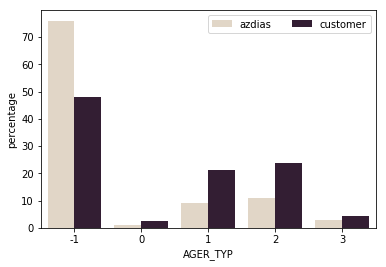

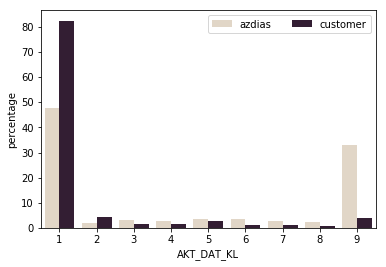

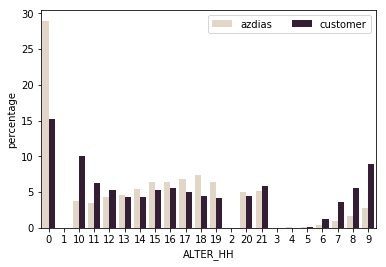

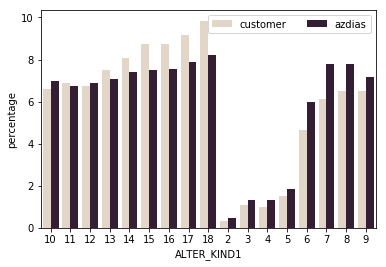

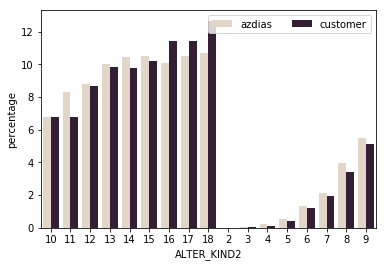

In [60]:
import matplotlib.pyplot as plt
from pathlib import Path

Path('img/exploration').mkdir(exist_ok=True, parents=True)

concatenated = pd.concat([pop_df.assign(dataset='azdias'), customers_df.assign(dataset='customer')])
vof = list(cat_col.keys()) # Variable Of Interest
for v in vof[0:5]:
    f, ax = plt.subplots()
    g = sns.barplot(x=v, 
                    y="percentage",
                    hue='dataset', 
                    data=concatenated.groupby(['dataset'])[v]
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .mul(100)
                         .reset_index()
                         .sort_values(v), 
                    palette="ch:.25")
    g.legend(ncol=2, loc="upper right", frameon=True)
    fig = g.get_figure()
    fig.savefig(Path('img/exploration').joinpath('barplot_' + v))

## Just view table data

In [3]:
pop_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


## Better understanding the data

In fact, explanations are provided in two Excel files : `DIAS Attributes - Values 2017.xlsx` and `DIAS Information Levels - Attributes 2017.xlsx`

From these files, one understand that in fact ALL data are categorical.
Also, signification for the categorical values is provided.
One sees that many categories have "unknown" categorical value ... That would be a nice way for categorizing NaN values !

**IN FACT THOSE ARE 2017 INFO AND DO NOT ALIGN WITH 2018 INFO**
**SOME COLUMNS ARE THEREFORE NOT FOUND IN THOSE EXCEL FILES AND VICE-VERSA**


### Load full categorial

In [5]:
cat_col_pop = {}
for col in pop_categories:
    cat_col_pop[col] = 'category'
        
cat_col_customer = {}
for col in customers_categories:
    cat_col_customer[col] = 'category'       

In [6]:
pop_df = pd.read_csv(pop_dataset_loc, sep=';', dtype = cat_col_pop)
customers_df = pd.read_csv(customers_dataset_loc, sep=';', dtype = cat_col_customer)

### Delete completely empty rows

In [7]:
drop_full_empty_row(pop_df)
drop_full_empty_row(customers_df, "customers_df")

Before deletion of full empty rows, we have 726424 samples in DataFrame data
After deletion of full empty rows, we have 726424 samples in DataFrame data
Before deletion of full empty rows, we have 191652 samples in customers_df data
After deletion of full empty rows, we have 191652 samples in customers_df data


### Delete rows where NaN values form a large percentage of the information

In [8]:
       
removed_col_pop = remove_insignificant_columns(pop_df)
removed_col_customer = remove_insignificant_columns(customers_df)

diff = set(removed_col_pop) - set(removed_col_customer)


for col in diff:
    if col in pop_df.columns:
        pop_df.drop(col, axis=1, inplace=True)
    if col in customers_df:
        customers_df.drop(col, axis=1, inplace=True)

# Note : I have checked, there are apparently
# no empty strings (e.g. '' or ' ') within the dataframe
# if that was the case, these should be handled properly as .isna() maps them to False

column ALTER_KIND1 has been dropped
column ALTER_KIND2 has been dropped
column ALTER_KIND3 has been dropped
column ALTER_KIND4 has been dropped
column ALTER_KIND1 has been dropped
column ALTER_KIND2 has been dropped
column ALTER_KIND3 has been dropped
column ALTER_KIND4 has been dropped


### Try extracting from info files to automate NaN filling

In [9]:
# construct nan values to be filled in for each attribute

nan_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx',
                    usecols=[1,3,4])
nan_info.columns = ["Attribute", "Value", "Meaning"]
nan_info.fillna(method='ffill', axis=0, inplace=True)

# store index of lines containing "unknown" levels
target_index = []
for i, row in nan_info.iterrows():
    try:
        if "unknown" in row.iloc[-1]:
            target_index.append(i)
    except:
        continue
        
nan_fill = nan_info.iloc[target_index, [0,1]]
nan_fill.set_index("Attribute", inplace=True) # index provide attribute, corresponding value is the NaN value for that attribute

In [10]:
# some attributes have two possible values
# identify which ones, consider only one value and make
# the dataframe pop_df & customer_df consistent with the one considered

replacements = {}
for i, row in nan_fill.iterrows():
    if type(row.values[0]) == str:
        if len(row.values[0].split()) > 1:
            kept, dropped = row.values[0].split()
            nan_fill.loc[i] = kept
            replacements[i] = {dropped:kept} # this will be used to replace in original dataframe
        

In [13]:
make_replacement(pop_df, replacements)
fill_na_presc(pop_df, nan_fill)
make_replacement(customers_df, replacements)
fill_na_presc(customers_df, nan_fill)

### Fill NaN that could not be filled through previous techniques

In [15]:
df_to_numeric(customers_df)
df_to_numeric(pop_df)

In [17]:
pop_non_numeric = get_non_numeric(pop_df)
pop_numeric = [col for col in pop_df.columns if col not in pop_non_numeric]

customers_non_numeric = get_non_numeric(customers_df)
customers_numeric = [col for col in customers_df.columns if col not in customers_non_numeric]

In [6]:
POP_NUMERIC_FILENAME = 'pop_df_numeric.pkl'
POP_NON_NUMERIC_FILENAME = 'pop_df_non_numeric.pkl'

In [18]:

pop_df[pop_non_numeric].to_pickle(pop_non_numeric_filename)
pop_df[pop_numeric].to_pickle(pop_numeric_filename)

In [23]:
customers_df[pop_non_numeric].to_pickle('customers_df_non_numeric.pkl')
customers_df[pop_numeric].to_pickle('customers_df_numeric.pkl')

In [29]:

pop_df = None
customers_df = None

gc.collect()

6574

In [2]:
mem = psutil.virtual_memory()
mem.

svmem(total=16820322304, available=16079503360, percent=4.4, used=473419776, free=15775965184, active=682991616, inactive=256245760, buffers=48435200, cached=522502144, shared=65536, slab=49676288)

In [ ]:
from sklearn.impute import KNNImputer

pop_df_numeric = pd.read_pickle(POP_NUMERIC_FILENAME)

imputer = KNNImputer(n_neighbors=4, weights="distance", copy=True)
imputer.fit_transform(pop_df_numeric)

KeyboardInterrupt: 

# Complete transformation pipeline

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

In [56]:
pop_df_mini = pop_df_partial.iloc[0:10,:].copy()

## Pre-transform operations

In [57]:
pop_df_selected = pop_df_mini

In [58]:
# specify columns to be dropped
pop_columns_to_drop = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

selected_columns = set(pop_df_selected.columns)-set(pop_columns_to_drop)
selected_columns = pop_df_selected[selected_columns].columns # because scikit pipeline requires index-type
object_columns = pop_df_selected.select_dtypes(object).columns

In [154]:
class HighCorr_remover(BaseEstimator, TransformerMixin):
    def __init__(self, corr_threshold=0.7):
        self.corr_threshold = corr_threshold
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        corr = X.corr()
        (main_elements, correlated_elements) = remove_high_corr(corr, self.corr_threshold)
        
        result = X.drop(correlated_elements, axis=1)
        self.features = result.columns
        
        return result
    def get_feature_names(self):
        return self.features

In [155]:
class To_numeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for col in X.columns:
            try:
                X[col] = pd.to_numeric(X[col], errors='raise')
            except Exception as e:
                continue
        
        self.features = X.columns

        return X
    def get_feature_names(self):
        return self.features

In [156]:
common_pipeline = Pipeline([
('highCorrRemover', HighCorr_remover())
                            ])

In [157]:
objects_pipeline = Pipeline([
('to_numeric', To_numeric())
                            ])

## Pipeline

In [158]:
full_pipeline = ColumnTransformer(
     [('all_selected_columns', common_pipeline, selected_columns),
      ('objects', objects_pipeline, object_columns)],
     remainder='drop')

In [159]:
full_pipeline

ColumnTransformer(transformers=[('all_selected_columns',
                                 Pipeline(steps=[('highCorrRemover',
                                                  HighCorr_remover())]),
                                 Index(['ALTER_KIND2', 'KBA13_KRSSEG_KLEIN', 'FINANZTYP', 'KBA05_FRAU',
       'KBA13_HALTER_45', 'KBA05_MOD2', 'KBA13_AUDI', 'KBA13_SEG_WOHNMOBILE',
       'D19_BANKEN_REST', 'KBA05_KW1',
       ...
       'KBA13_ALTERHALTER_61', 'KBA13_VORB_1_2', 'D19_BANKEN_ONLINE_DATUM',
       'KBA13_CCM_3000', 'KBA13_KW_30', 'FINANZ_HAUSBAUER', 'D19_BANKEN_DATUM',
       'FINANZ_ANLEGER', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX'],
      dtype='object', length=364)),
                                ('objects',
                                 Pipeline(steps=[('to_numeric', To_numeric())]),
                                 Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object'

In [160]:
full_pipeline.fit(pop_df_selected)

ColumnTransformer(transformers=[('all_selected_columns',
                                 Pipeline(steps=[('highCorrRemover',
                                                  HighCorr_remover())]),
                                 Index(['ALTER_KIND2', 'KBA13_KRSSEG_KLEIN', 'FINANZTYP', 'KBA05_FRAU',
       'KBA13_HALTER_45', 'KBA05_MOD2', 'KBA13_AUDI', 'KBA13_SEG_WOHNMOBILE',
       'D19_BANKEN_REST', 'KBA05_KW1',
       ...
       'KBA13_ALTERHALTER_61', 'KBA13_VORB_1_2', 'D19_BANKEN_ONLINE_DATUM',
       'KBA13_CCM_3000', 'KBA13_KW_30', 'FINANZ_HAUSBAUER', 'D19_BANKEN_DATUM',
       'FINANZ_ANLEGER', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX'],
      dtype='object', length=364)),
                                ('objects',
                                 Pipeline(steps=[('to_numeric', To_numeric())]),
                                 Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object'

In [161]:
full_pipeline.transformers_[0][1].steps[0][1].get_feature_names()

Index(['ALTER_KIND2', 'KBA13_KRSSEG_KLEIN', 'FINANZTYP', 'KBA05_FRAU',
       'KBA13_HALTER_45', 'KBA05_MOD2', 'KBA13_AUDI', 'KBA13_SEG_WOHNMOBILE',
       'D19_BANKEN_REST', 'KBA05_KW1',
       ...
       'KBA13_KRSSEG_OBER', 'HH_DELTA_FLAG', 'ANZ_PERSONEN', 'KBA05_MAXAH',
       'D19_VERSI_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12',
       'D19_BANKEN_ONLINE_DATUM', 'KBA13_KW_30', 'D19_KINDERARTIKEL'],
      dtype='object', length=306)

In [162]:
full_pipeline.transformers_[1][1].steps[0][1].get_feature_names()

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [143]:
full_pipeline.get_feature_names()

AttributeError: Transformer all_selected_columns (type Pipeline) does not provide get_feature_names.

In [120]:
pop_array_processed = full_pipeline.fit_transform(pop_df_selected)

In [121]:
pop_array_processed.get_feature_names()

AttributeError: 'numpy.ndarray' object has no attribute 'get_feature_names'

In [37]:
pop_df_selected.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
1,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
2,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0
3,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1.0,1.0,1.0
4,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4.0,2.0,3.0


In [38]:
pop_df_processed = pandas.DataFrame

AttributeError: 'numpy.ndarray' object has no attribute 'head'

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

# DATA INFORMATION